In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os

project_root = os.path.abspath('../..')
data_root = os.path.join(project_root, 'data')

# Solução de aprendizado de máquina para classificação de sobrenomes
* Classificador n-gramático: constrói perfis de n-gramas para categorias dos dados de treino, a partir dos exemplos providos, e gera uma inferência construindo um perfil para a palavra a ser classificada e comparando-o a cada um dos perfis em que foi treinado, retornando a categoria com menor distância.
  * Hiperparâmetros:
    1. n = tamanho dos n-gramas (em caracteres)
    2. top_k = quantidade de n-gramas mais frequentes considerados para construir um perfil de categoria
    3. distance = métricas de distância para inferência:
      * 'rank': é o mesmo que out-of-place measure proposta por Cavnar-Trenkle; a distância de ranking (posição dos n-gramas ordenados por número de ocorrências) entre o perfil da palavra e de cada uma das categorias
      * 'cosine_tfidf': calcula a distância de coseno entre um vetor tf-idf com n-gramas dos perfis das categorias e da palavra a ser classificada
      * 'match_rate': baseado em Chew et al [https://journal.icter.org/index.php/ICTer/article/download/45/10], calcula a proporção de n-gramas observados, comparando os perfis pré-calculados e a palavra a ser classificada; a distância é definida como 1 - (n-gramas compatíveis/total de n-gramas possíveis)

* Cada uma das métricas de distância armazena os perfis em uma estrutura de dados apropriada para seu funcionamento dentro do modelo.
* Tanto o fit do modelo quanto a inferência utilizam largamente operações vetoriais para otimizar o tempo de execução.

In [15]:
names_origins_gt = pd.read_csv(os.path.join(data_root, 'outputs', 'final_rne_ground_truth.csv'))

In [21]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
from itertools import product
from tqdm import tqdm
import numpy as np
import pandas as pd
import time

import os

# output_dir = os.path.join(data_root, "classifier", "ensemble_eval_results")
output_dir = './test'
os.makedirs(output_dir, exist_ok=True)

from models import NGramClassifier, LIGAClassifier, NgramEnsembleClassifier

n_repeats = 30
n_folds = 5

# Define NGram classifiers
ngram_distances = ['rank', 'cosine_tfidf', 'match_rate']
ngram_models = {
    f"NGram (distance={dist})": (lambda dist=dist: NGramClassifier(n=3, top_k=1250, distance=dist))
    for dist in ngram_distances
}

# Define LIGA classifiers
liga_models = {
    f"LIGA (log={log}, median={median})": lambda log=log, median=median: LIGAClassifier(n=3, use_log=log, use_median=median)
    for log, median in product([False, True], [False, True])
}

ensemble_model = {
    "NgramEnsemble": lambda: NgramEnsembleClassifier()
}

# for model in [ngram_models, liga_models, ensemble_model]:
#   for name, factory in model.items():
#     print(name, factory)
#     display(factory())

models_to_evaluate = {**ngram_models, **liga_models, **ensemble_model}
# models_to_evaluate = {**ngram_models, **liga_models}
results = {name: [] for name in models_to_evaluate}

total_steps = n_repeats * len(models_to_evaluate) * (n_folds + 1)
pbar = tqdm(total=total_steps, desc="Evaluating all models", leave=False)

for it in range(n_repeats):
    # Stratified train/test split for this iteration
    rne_train, rne_holdout = train_test_split(
        names_origins_gt, test_size=0.2, stratify=names_origins_gt['origin'], random_state=it
    )
    X_train_all = rne_train['surname'].values
    y_train_all = rne_train['origin'].values

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=it)

    for model_name, model_factory in models_to_evaluate.items():
        # Cross-validation on training split
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_all, y_train_all)):
            X_train = X_train_all[train_idx]
            y_train = y_train_all[train_idx]
            X_val = X_train_all[val_idx]
            y_val = y_train_all[val_idx]

            start_time = time.time()
            clf = model_factory()
            clf.fit(X_train, y_train)
            preds = clf.predict(X_val)
            report = classification_report(y_val, preds, output_dict=True)

            result = {
                'iteration': it + 1,
                'fold': fold + 1,
                'is_holdout': False,
                'model_name': model_name,
                'parameter_setting': model_name.split("(", 1)[-1].rstrip(")"),
                'execution_time': time.time() - start_time
            }

            def get_model_classes(clf):
              if hasattr(clf, 'encoder_') and hasattr(clf.encoder_, 'classes_'):
                  return set(clf.encoder_.classes_)
              elif hasattr(clf, 'lang_list_'):
                  return set(clf.lang_list_)
              elif hasattr(clf, 'label_order_'):
                  return set(clf.label_order_)
              else:
                  raise AttributeError("Classifier does not expose class labels.")

            model_classes = get_model_classes(clf)

            for label, metrics in report.items():
                if label in model_classes:
                    result[f'{label}_f1_score'] = metrics['f1-score']
                elif label == 'macro avg':
                    result['macro_avg_f1_score'] = metrics['f1-score']

            results[model_name].append(result)
            pbar.update(1)

        # Evaluate on the holdout set
        start_time = time.time()
        clf = model_factory()
        clf.fit(X_train_all, y_train_all)
        preds = clf.predict(rne_holdout['surname'].values)
        report = classification_report(rne_holdout['origin'].values, preds, output_dict=True)



        result = {
            'iteration': it + 1,
            'fold': 'holdout',
            'is_holdout': True,
            'model_name': model_name,
            'parameter_setting': model_name.split("(", 1)[-1].rstrip(")"),
            'execution_time': time.time() - start_time
        }

        model_classes = get_model_classes(clf)

        for label, metrics in report.items():
            if label in model_classes:
                result[f'{label}_f1_score'] = metrics['f1-score']
            elif label == 'macro avg':
                result['macro_avg_f1_score'] = metrics['f1-score']
        results[model_name].append(result)
        pbar.update(1)

    # After one full iteration (all models evaluated)
    all_iter_results = []
    for model_name, res in results.items():
        for row in res:
            all_iter_results.append(row)

    # Save to CSV
    df_iter = pd.DataFrame(all_iter_results)
    filename = f"results_up_to_iter_{it+1}.csv"
    df_iter.to_csv(os.path.join(output_dir, filename), index=False)

all_results_flat = [r for model_res in results.values() for r in model_res]
df_all = pd.DataFrame(all_results_flat)
df_all.to_csv(os.path.join(output_dir, "all_results.csv"), index=False)


pbar.close()


Evaluating all models:   3%|▎         | 42/1440 [02:00<2:25:43,  6.25s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27681
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132916
[LightGBM] [Info] Start training from score -2.112514
[LightGBM] [Info] Start training from score -2.306688
[LightGBM] [Info] Start training from score -2.872233
[LightGBM] [Info] Start training from score -1.940708
[LightGBM] [Info] Start training from score -1.357868


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   3%|▎         | 43/1440 [03:42<13:33:26, 34.94s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27659
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   3%|▎         | 44/1440 [05:21<21:02:06, 54.25s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27652
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   3%|▎         | 45/1440 [07:02<26:22:18, 68.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27666
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   3%|▎         | 46/1440 [08:43<30:09:09, 77.87s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27656
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133092
[LightGBM] [Info] Start training from score -2.112324
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872143
[LightGBM] [Info] Start training from score -1.940736
[LightGBM] [Info] Start training from score -1.357777


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   3%|▎         | 47/1440 [10:20<32:25:04, 83.78s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27676
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   6%|▋         | 90/1440 [14:24<2:18:57,  6.18s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27663
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132908
[LightGBM] [Info] Start training from score -2.112505
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872225
[LightGBM] [Info] Start training from score -1.940817
[LightGBM] [Info] Start training from score -1.357859


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   6%|▋         | 91/1440 [16:04<12:46:28, 34.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27613
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   6%|▋         | 92/1440 [17:44<20:11:06, 53.91s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27614
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   6%|▋         | 93/1440 [19:31<26:08:38, 69.87s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27618
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133092
[LightGBM] [Info] Start training from score -2.112324
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872143
[LightGBM] [Info] Start training from score -1.940736
[LightGBM] [Info] Start training from score -1.357777


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   7%|▋         | 94/1440 [21:10<29:25:02, 78.68s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27683
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:   7%|▋         | 95/1440 [22:49<31:42:30, 84.87s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27632
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  10%|▉         | 138/1440 [26:52<2:11:47,  6.07s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27601
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.133100
[LightGBM] [Info] Start training from score -2.112332
[LightGBM] [Info] Start training from score -2.306523
[LightGBM] [Info] Start training from score -2.872151
[LightGBM] [Info] Start training from score -1.940744
[LightGBM] [Info] Start training from score -1.357785


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  10%|▉         | 139/1440 [28:31<12:19:58, 34.13s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27679
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133050
[LightGBM] [Info] Start training from score -2.112382
[LightGBM] [Info] Start training from score -2.306473
[LightGBM] [Info] Start training from score -2.872101
[LightGBM] [Info] Start training from score -1.940575
[LightGBM] [Info] Start training from score -1.357948


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  10%|▉         | 140/1440 [30:12<19:28:54, 53.95s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27655
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  10%|▉         | 141/1440 [31:51<24:22:14, 67.54s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27626
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  10%|▉         | 142/1440 [33:30<27:45:44, 77.00s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27608
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  10%|▉         | 143/1440 [35:09<30:09:36, 83.71s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27634
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  13%|█▎        | 186/1440 [39:14<2:09:53,  6.21s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27665
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132865
[LightGBM] [Info] Start training from score -2.112363
[LightGBM] [Info] Start training from score -2.306554
[LightGBM] [Info] Start training from score -2.872182
[LightGBM] [Info] Start training from score -1.940775
[LightGBM] [Info] Start training from score -1.358029


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  13%|█▎        | 187/1440 [40:52<11:47:10, 33.86s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27678
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  13%|█▎        | 188/1440 [42:32<18:40:36, 53.70s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27660
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  13%|█▎        | 189/1440 [44:10<23:17:28, 67.02s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27648
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  13%|█▎        | 190/1440 [45:50<26:40:40, 76.83s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27656
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  13%|█▎        | 191/1440 [47:29<28:58:20, 83.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27678
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  16%|█▋        | 234/1440 [51:30<2:03:00,  6.12s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27643
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132911
[LightGBM] [Info] Start training from score -2.112409
[LightGBM] [Info] Start training from score -2.306683
[LightGBM] [Info] Start training from score -2.872229
[LightGBM] [Info] Start training from score -1.940821
[LightGBM] [Info] Start training from score -1.357863


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  16%|█▋        | 235/1440 [53:09<11:25:49, 34.15s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27681
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  16%|█▋        | 236/1440 [54:48<17:52:57, 53.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27628
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  16%|█▋        | 237/1440 [56:27<22:27:41, 67.22s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27650
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  17%|█▋        | 238/1440 [58:06<25:33:28, 76.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27680
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  17%|█▋        | 239/1440 [59:56<28:56:26, 86.75s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27661
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  20%|█▉        | 282/1440 [1:03:55<1:55:51,  6.00s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27689
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.133100
[LightGBM] [Info] Start training from score -2.112332
[LightGBM] [Info] Start training from score -2.306523
[LightGBM] [Info] Start training from score -2.872151
[LightGBM] [Info] Start training from score -1.940744
[LightGBM] [Info] Start training from score -1.357785


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  20%|█▉        | 283/1440 [1:05:33<10:47:13, 33.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27709
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133050
[LightGBM] [Info] Start training from score -2.112382
[LightGBM] [Info] Start training from score -2.306473
[LightGBM] [Info] Start training from score -2.872101
[LightGBM] [Info] Start training from score -1.940575
[LightGBM] [Info] Start training from score -1.357948


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  20%|█▉        | 284/1440 [1:07:13<17:09:56, 53.46s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27686
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  20%|█▉        | 285/1440 [1:08:54<21:41:19, 67.60s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27688
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  20%|█▉        | 286/1440 [1:10:33<24:43:07, 77.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27690
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  20%|█▉        | 287/1440 [1:12:11<26:43:46, 83.46s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27713
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  23%|██▎       | 330/1440 [1:16:17<1:54:10,  6.17s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27641
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132865
[LightGBM] [Info] Start training from score -2.112363
[LightGBM] [Info] Start training from score -2.306554
[LightGBM] [Info] Start training from score -2.872182
[LightGBM] [Info] Start training from score -1.940775
[LightGBM] [Info] Start training from score -1.358029


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  23%|██▎       | 331/1440 [1:17:57<10:35:49, 34.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27658
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  23%|██▎       | 332/1440 [1:19:37<16:38:42, 54.08s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27616
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  23%|██▎       | 333/1440 [1:21:17<20:53:44, 67.95s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27601
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  23%|██▎       | 334/1440 [1:22:57<23:49:11, 77.53s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27619
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  23%|██▎       | 335/1440 [1:24:36<25:45:10, 83.90s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27643
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  26%|██▋       | 378/1440 [1:28:39<1:47:47,  6.09s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27709
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132908
[LightGBM] [Info] Start training from score -2.112505
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872225
[LightGBM] [Info] Start training from score -1.940817
[LightGBM] [Info] Start training from score -1.357859


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  26%|██▋       | 379/1440 [1:30:20<10:09:28, 34.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27648
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  26%|██▋       | 380/1440 [1:32:00<15:54:53, 54.05s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27617
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132857
[LightGBM] [Info] Start training from score -2.112355
[LightGBM] [Info] Start training from score -2.306628
[LightGBM] [Info] Start training from score -2.872174
[LightGBM] [Info] Start training from score -1.940767
[LightGBM] [Info] Start training from score -1.358021


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  26%|██▋       | 381/1440 [1:33:40<19:56:30, 67.79s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27631
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  27%|██▋       | 382/1440 [1:35:19<22:43:14, 77.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27617
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  27%|██▋       | 383/1440 [1:36:59<24:42:08, 84.13s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27652
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  30%|██▉       | 426/1440 [1:41:02<1:43:05,  6.10s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27630
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.133105
[LightGBM] [Info] Start training from score -2.112437
[LightGBM] [Info] Start training from score -2.306528
[LightGBM] [Info] Start training from score -2.872156
[LightGBM] [Info] Start training from score -1.940630
[LightGBM] [Info] Start training from score -1.357790


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  30%|██▉       | 427/1440 [1:42:41<9:36:16, 34.13s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27650
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133050
[LightGBM] [Info] Start training from score -2.112382
[LightGBM] [Info] Start training from score -2.306473
[LightGBM] [Info] Start training from score -2.872101
[LightGBM] [Info] Start training from score -1.940575
[LightGBM] [Info] Start training from score -1.357948


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  30%|██▉       | 428/1440 [1:44:19<14:59:33, 53.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27669
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132857
[LightGBM] [Info] Start training from score -2.112355
[LightGBM] [Info] Start training from score -2.306628
[LightGBM] [Info] Start training from score -2.872174
[LightGBM] [Info] Start training from score -1.940767
[LightGBM] [Info] Start training from score -1.358021


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  30%|██▉       | 429/1440 [1:45:59<18:52:41, 67.22s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27624
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  30%|██▉       | 430/1440 [1:47:37<21:29:50, 76.62s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27625
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  30%|██▉       | 431/1440 [1:49:16<23:18:26, 83.16s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27642
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  33%|███▎      | 474/1440 [1:53:19<1:39:02,  6.15s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27632
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132870
[LightGBM] [Info] Start training from score -2.112468
[LightGBM] [Info] Start training from score -2.306559
[LightGBM] [Info] Start training from score -2.872187
[LightGBM] [Info] Start training from score -1.940661
[LightGBM] [Info] Start training from score -1.358034


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  33%|███▎      | 475/1440 [1:54:59<9:09:01, 34.14s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27644
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  33%|███▎      | 476/1440 [1:56:39<14:23:56, 53.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27712
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  33%|███▎      | 477/1440 [1:58:16<17:54:50, 66.97s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27695
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133092
[LightGBM] [Info] Start training from score -2.112324
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872143
[LightGBM] [Info] Start training from score -1.940736
[LightGBM] [Info] Start training from score -1.357777


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  33%|███▎      | 478/1440 [1:59:55<20:25:54, 76.46s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27653
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  33%|███▎      | 479/1440 [2:01:34<22:12:04, 83.17s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27676
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  36%|███▋      | 522/1440 [2:05:38<1:34:11,  6.16s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27674
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132908
[LightGBM] [Info] Start training from score -2.112505
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872225
[LightGBM] [Info] Start training from score -1.940817
[LightGBM] [Info] Start training from score -1.357859


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  36%|███▋      | 523/1440 [2:07:19<8:47:12, 34.50s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27691
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133050
[LightGBM] [Info] Start training from score -2.112382
[LightGBM] [Info] Start training from score -2.306473
[LightGBM] [Info] Start training from score -2.872101
[LightGBM] [Info] Start training from score -1.940575
[LightGBM] [Info] Start training from score -1.357948


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  36%|███▋      | 524/1440 [2:09:00<13:50:43, 54.41s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27611
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133054
[LightGBM] [Info] Start training from score -2.112286
[LightGBM] [Info] Start training from score -2.306560
[LightGBM] [Info] Start training from score -2.872105
[LightGBM] [Info] Start training from score -1.940579
[LightGBM] [Info] Start training from score -1.357952


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  36%|███▋      | 525/1440 [2:10:39<17:16:51, 67.99s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27613
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  37%|███▋      | 526/1440 [2:12:20<19:43:55, 77.72s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27627
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  37%|███▋      | 527/1440 [2:14:08<22:02:37, 86.92s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27645
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  40%|███▉      | 570/1440 [2:18:12<1:28:03,  6.07s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27640
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132911
[LightGBM] [Info] Start training from score -2.112409
[LightGBM] [Info] Start training from score -2.306683
[LightGBM] [Info] Start training from score -2.872229
[LightGBM] [Info] Start training from score -1.940821
[LightGBM] [Info] Start training from score -1.357863


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  40%|███▉      | 571/1440 [2:19:51<8:13:56, 34.10s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27656
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  40%|███▉      | 572/1440 [2:21:32<13:01:37, 54.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27665
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  40%|███▉      | 573/1440 [2:23:12<16:18:52, 67.74s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27650
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  40%|███▉      | 574/1440 [2:24:50<18:28:50, 76.83s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27697
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  40%|███▉      | 575/1440 [2:26:29<20:04:23, 83.54s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27672
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  43%|████▎     | 618/1440 [2:30:35<1:25:19,  6.23s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27652
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.133062
[LightGBM] [Info] Start training from score -2.112294
[LightGBM] [Info] Start training from score -2.306485
[LightGBM] [Info] Start training from score -2.872113
[LightGBM] [Info] Start training from score -1.940588
[LightGBM] [Info] Start training from score -1.357960


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  43%|████▎     | 619/1440 [2:32:15<7:49:57, 34.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27703
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133050
[LightGBM] [Info] Start training from score -2.112382
[LightGBM] [Info] Start training from score -2.306473
[LightGBM] [Info] Start training from score -2.872101
[LightGBM] [Info] Start training from score -1.940575
[LightGBM] [Info] Start training from score -1.357948


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  43%|████▎     | 620/1440 [2:33:54<12:14:21, 53.73s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27612
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  43%|████▎     | 621/1440 [2:35:33<15:20:18, 67.42s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27620
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  43%|████▎     | 622/1440 [2:37:12<17:27:48, 76.86s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27664
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  43%|████▎     | 623/1440 [2:38:53<19:04:00, 84.01s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27639
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  46%|████▋     | 666/1440 [2:42:56<1:19:14,  6.14s/it] 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27648
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132916
[LightGBM] [Info] Start training from score -2.112514
[LightGBM] [Info] Start training from score -2.306688
[LightGBM] [Info] Start training from score -2.872233
[LightGBM] [Info] Start training from score -1.940708
[LightGBM] [Info] Start training from score -1.357868


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  46%|████▋     | 667/1440 [2:44:45<7:57:38, 37.07s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27619
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  46%|████▋     | 668/1440 [2:46:24<11:55:18, 55.59s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27601
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133092
[LightGBM] [Info] Start training from score -2.112324
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872143
[LightGBM] [Info] Start training from score -1.940736
[LightGBM] [Info] Start training from score -1.357777


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  46%|████▋     | 669/1440 [2:48:03<14:43:06, 68.72s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27632
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  47%|████▋     | 670/1440 [2:49:43<16:41:48, 78.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27658
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  47%|████▋     | 671/1440 [2:51:22<18:01:04, 84.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27628
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  50%|████▉     | 714/1440 [2:55:24<1:12:59,  6.03s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27686
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132916
[LightGBM] [Info] Start training from score -2.112514
[LightGBM] [Info] Start training from score -2.306688
[LightGBM] [Info] Start training from score -2.872233
[LightGBM] [Info] Start training from score -1.940708
[LightGBM] [Info] Start training from score -1.357868


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  50%|████▉     | 715/1440 [2:57:04<6:53:13, 34.20s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27614
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  50%|████▉     | 716/1440 [2:58:44<10:52:40, 54.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27664
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133045
[LightGBM] [Info] Start training from score -2.112277
[LightGBM] [Info] Start training from score -2.306468
[LightGBM] [Info] Start training from score -2.872096
[LightGBM] [Info] Start training from score -1.940689
[LightGBM] [Info] Start training from score -1.357943


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  50%|████▉     | 717/1440 [3:00:24<13:38:42, 67.94s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27654
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  50%|████▉     | 718/1440 [3:02:04<15:32:39, 77.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27615
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  50%|████▉     | 719/1440 [3:03:44<16:50:29, 84.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27644
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  53%|█████▎    | 762/1440 [3:07:48<1:09:58,  6.19s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27639
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132908
[LightGBM] [Info] Start training from score -2.112505
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872225
[LightGBM] [Info] Start training from score -1.940817
[LightGBM] [Info] Start training from score -1.357859


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  53%|█████▎    | 763/1440 [3:09:29<6:30:06, 34.57s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27630
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  53%|█████▎    | 764/1440 [3:11:08<10:08:04, 53.97s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27691
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133092
[LightGBM] [Info] Start training from score -2.112324
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872143
[LightGBM] [Info] Start training from score -1.940736
[LightGBM] [Info] Start training from score -1.357777


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  53%|█████▎    | 765/1440 [3:12:48<12:42:42, 67.80s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27652
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  53%|█████▎    | 766/1440 [3:14:27<14:26:22, 77.12s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27686
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  53%|█████▎    | 767/1440 [3:16:07<15:41:12, 83.91s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27668
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  56%|█████▋    | 810/1440 [3:20:11<1:04:21,  6.13s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27671
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132908
[LightGBM] [Info] Start training from score -2.112505
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872225
[LightGBM] [Info] Start training from score -1.940817
[LightGBM] [Info] Start training from score -1.357859


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  56%|█████▋    | 811/1440 [3:21:50<5:55:20, 33.90s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27651
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  56%|█████▋    | 812/1440 [3:23:30<9:22:58, 53.79s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27652
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  56%|█████▋    | 813/1440 [3:25:09<11:44:58, 67.46s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27612
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  57%|█████▋    | 814/1440 [3:26:48<13:22:12, 76.89s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27603
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132857
[LightGBM] [Info] Start training from score -2.112355
[LightGBM] [Info] Start training from score -2.306628
[LightGBM] [Info] Start training from score -2.872174
[LightGBM] [Info] Start training from score -1.940767
[LightGBM] [Info] Start training from score -1.358021


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  57%|█████▋    | 815/1440 [3:28:28<14:32:57, 83.80s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27631
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  60%|█████▉    | 858/1440 [3:32:33<59:29,  6.13s/it]   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27662
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132911
[LightGBM] [Info] Start training from score -2.112409
[LightGBM] [Info] Start training from score -2.306683
[LightGBM] [Info] Start training from score -2.872229
[LightGBM] [Info] Start training from score -1.940821
[LightGBM] [Info] Start training from score -1.357863


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  60%|█████▉    | 859/1440 [3:34:13<5:30:00, 34.08s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27658
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133050
[LightGBM] [Info] Start training from score -2.112382
[LightGBM] [Info] Start training from score -2.306473
[LightGBM] [Info] Start training from score -2.872101
[LightGBM] [Info] Start training from score -1.940575
[LightGBM] [Info] Start training from score -1.357948


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  60%|█████▉    | 860/1440 [3:35:51<8:36:06, 53.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27661
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133050
[LightGBM] [Info] Start training from score -2.112382
[LightGBM] [Info] Start training from score -2.306473
[LightGBM] [Info] Start training from score -2.872101
[LightGBM] [Info] Start training from score -1.940575
[LightGBM] [Info] Start training from score -1.357948


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  60%|█████▉    | 861/1440 [3:37:30<10:46:44, 67.02s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27655
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  60%|█████▉    | 862/1440 [3:39:10<12:20:46, 76.90s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27697
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  60%|█████▉    | 863/1440 [3:40:50<13:27:15, 83.94s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27693
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  63%|██████▎   | 906/1440 [3:45:04<54:27,  6.12s/it]   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27654
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132870
[LightGBM] [Info] Start training from score -2.112468
[LightGBM] [Info] Start training from score -2.306559
[LightGBM] [Info] Start training from score -2.872187
[LightGBM] [Info] Start training from score -1.940661
[LightGBM] [Info] Start training from score -1.358034


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  63%|██████▎   | 907/1440 [3:46:44<5:03:19, 34.15s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27652
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  63%|██████▎   | 908/1440 [3:48:23<7:56:46, 53.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27661
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133092
[LightGBM] [Info] Start training from score -2.112324
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872143
[LightGBM] [Info] Start training from score -1.940736
[LightGBM] [Info] Start training from score -1.357777


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  63%|██████▎   | 909/1440 [3:50:04<9:59:49, 67.78s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27683
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  63%|██████▎   | 910/1440 [3:51:52<11:46:55, 80.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27644
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  63%|██████▎   | 911/1440 [3:53:31<12:34:15, 85.55s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27682
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  66%|██████▋   | 954/1440 [3:57:34<50:08,  6.19s/it]   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27654
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132911
[LightGBM] [Info] Start training from score -2.112409
[LightGBM] [Info] Start training from score -2.306683
[LightGBM] [Info] Start training from score -2.872229
[LightGBM] [Info] Start training from score -1.940821
[LightGBM] [Info] Start training from score -1.357863


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  66%|██████▋   | 955/1440 [3:59:14<4:36:43, 34.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27660
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  66%|██████▋   | 956/1440 [4:00:54<7:15:14, 53.96s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27681
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  66%|██████▋   | 957/1440 [4:02:33<9:04:45, 67.67s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27655
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  67%|██████▋   | 958/1440 [4:04:12<10:19:02, 77.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27651
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  67%|██████▋   | 959/1440 [4:05:53<11:13:23, 84.00s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27675
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  70%|██████▉   | 1002/1440 [4:09:57<44:21,  6.08s/it]  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27645
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132908
[LightGBM] [Info] Start training from score -2.112505
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872225
[LightGBM] [Info] Start training from score -1.940817
[LightGBM] [Info] Start training from score -1.357859


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  70%|██████▉   | 1003/1440 [4:11:35<4:06:46, 33.88s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27622
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  70%|██████▉   | 1004/1440 [4:13:14<6:27:25, 53.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27633
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133092
[LightGBM] [Info] Start training from score -2.112324
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872143
[LightGBM] [Info] Start training from score -1.940736
[LightGBM] [Info] Start training from score -1.357777


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  70%|██████▉   | 1005/1440 [4:14:54<8:07:37, 67.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27659
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  70%|██████▉   | 1006/1440 [4:16:34<9:18:46, 77.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27646
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  70%|██████▉   | 1007/1440 [4:18:22<10:24:00, 86.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27650
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  73%|███████▎  | 1050/1440 [4:22:27<40:03,  6.16s/it]   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27690
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132916
[LightGBM] [Info] Start training from score -2.112514
[LightGBM] [Info] Start training from score -2.306688
[LightGBM] [Info] Start training from score -2.872233
[LightGBM] [Info] Start training from score -1.940708
[LightGBM] [Info] Start training from score -1.357868


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  73%|███████▎  | 1051/1440 [4:24:08<3:42:39, 34.34s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27626
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  73%|███████▎  | 1052/1440 [4:25:47<5:47:40, 53.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27645
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  73%|███████▎  | 1053/1440 [4:27:28<7:19:46, 68.18s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27635
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  73%|███████▎  | 1054/1440 [4:29:08<8:18:21, 77.46s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27696
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132857
[LightGBM] [Info] Start training from score -2.112355
[LightGBM] [Info] Start training from score -2.306628
[LightGBM] [Info] Start training from score -2.872174
[LightGBM] [Info] Start training from score -1.940767
[LightGBM] [Info] Start training from score -1.358021


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  73%|███████▎  | 1055/1440 [4:30:57<9:19:23, 87.18s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27660
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  76%|███████▋  | 1098/1440 [4:35:02<35:02,  6.15s/it]   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27635
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132870
[LightGBM] [Info] Start training from score -2.112468
[LightGBM] [Info] Start training from score -2.306559
[LightGBM] [Info] Start training from score -2.872187
[LightGBM] [Info] Start training from score -1.940661
[LightGBM] [Info] Start training from score -1.358034


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  76%|███████▋  | 1099/1440 [4:36:42<3:15:31, 34.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27623
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133050
[LightGBM] [Info] Start training from score -2.112382
[LightGBM] [Info] Start training from score -2.306473
[LightGBM] [Info] Start training from score -2.872101
[LightGBM] [Info] Start training from score -1.940575
[LightGBM] [Info] Start training from score -1.357948


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  76%|███████▋  | 1100/1440 [4:38:21<5:04:49, 53.79s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27627
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133092
[LightGBM] [Info] Start training from score -2.112324
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872143
[LightGBM] [Info] Start training from score -1.940736
[LightGBM] [Info] Start training from score -1.357777


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  76%|███████▋  | 1101/1440 [4:39:59<6:19:04, 67.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27634
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  77%|███████▋  | 1102/1440 [4:41:37<7:10:11, 76.36s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27657
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  77%|███████▋  | 1103/1440 [4:43:16<7:47:40, 83.27s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27649
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  80%|███████▉  | 1146/1440 [4:47:21<29:41,  6.06s/it]  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27682
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132911
[LightGBM] [Info] Start training from score -2.112409
[LightGBM] [Info] Start training from score -2.306683
[LightGBM] [Info] Start training from score -2.872229
[LightGBM] [Info] Start training from score -1.940821
[LightGBM] [Info] Start training from score -1.357863


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  80%|███████▉  | 1147/1440 [4:49:01<2:47:45, 34.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27613
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  80%|███████▉  | 1148/1440 [4:50:42<4:24:06, 54.27s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27620
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  80%|███████▉  | 1149/1440 [4:52:23<5:31:03, 68.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27648
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  80%|███████▉  | 1150/1440 [4:54:02<6:14:27, 77.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27607
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  80%|███████▉  | 1151/1440 [4:55:41<6:45:26, 84.17s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27638
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  83%|████████▎ | 1194/1440 [4:59:45<25:09,  6.14s/it]  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27612
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132908
[LightGBM] [Info] Start training from score -2.112505
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872225
[LightGBM] [Info] Start training from score -1.940817
[LightGBM] [Info] Start training from score -1.357859


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  83%|████████▎ | 1195/1440 [5:01:25<2:20:03, 34.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27625
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  83%|████████▎ | 1196/1440 [5:03:05<3:38:49, 53.81s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27604
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132857
[LightGBM] [Info] Start training from score -2.112355
[LightGBM] [Info] Start training from score -2.306628
[LightGBM] [Info] Start training from score -2.872174
[LightGBM] [Info] Start training from score -1.940767
[LightGBM] [Info] Start training from score -1.358021


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  83%|████████▎ | 1197/1440 [5:04:44<4:32:59, 67.41s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27681
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  83%|████████▎ | 1198/1440 [5:06:22<5:09:36, 76.76s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27644
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  83%|████████▎ | 1199/1440 [5:08:01<5:34:26, 83.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27642
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  86%|████████▋ | 1242/1440 [5:12:02<19:49,  6.01s/it]  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27667
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.133105
[LightGBM] [Info] Start training from score -2.112437
[LightGBM] [Info] Start training from score -2.306528
[LightGBM] [Info] Start training from score -2.872156
[LightGBM] [Info] Start training from score -1.940630
[LightGBM] [Info] Start training from score -1.357790


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  86%|████████▋ | 1243/1440 [5:13:41<1:51:34, 33.98s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27638
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  86%|████████▋ | 1244/1440 [5:15:20<2:55:21, 53.68s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27659
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132857
[LightGBM] [Info] Start training from score -2.112355
[LightGBM] [Info] Start training from score -2.306628
[LightGBM] [Info] Start training from score -2.872174
[LightGBM] [Info] Start training from score -1.940767
[LightGBM] [Info] Start training from score -1.358021


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  86%|████████▋ | 1245/1440 [5:16:59<3:38:37, 67.27s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27659
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  87%|████████▋ | 1246/1440 [5:18:39<4:08:32, 76.87s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27671
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  87%|████████▋ | 1247/1440 [5:20:18<4:28:54, 83.60s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27651
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  90%|████████▉ | 1290/1440 [5:24:23<15:12,  6.08s/it]  

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27650
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.133105
[LightGBM] [Info] Start training from score -2.112437
[LightGBM] [Info] Start training from score -2.306528
[LightGBM] [Info] Start training from score -2.872156
[LightGBM] [Info] Start training from score -1.940630
[LightGBM] [Info] Start training from score -1.357790


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  90%|████████▉ | 1291/1440 [5:26:13<1:32:05, 37.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27677
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132853
[LightGBM] [Info] Start training from score -2.112451
[LightGBM] [Info] Start training from score -2.306542
[LightGBM] [Info] Start training from score -2.872170
[LightGBM] [Info] Start training from score -1.940763
[LightGBM] [Info] Start training from score -1.358017


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  90%|████████▉ | 1292/1440 [5:27:52<2:17:50, 55.88s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27693
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132857
[LightGBM] [Info] Start training from score -2.112355
[LightGBM] [Info] Start training from score -2.306628
[LightGBM] [Info] Start training from score -2.872174
[LightGBM] [Info] Start training from score -1.940767
[LightGBM] [Info] Start training from score -1.358021


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  90%|████████▉ | 1293/1440 [5:29:33<2:50:04, 69.42s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27648
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  90%|████████▉ | 1294/1440 [5:31:15<3:12:14, 79.00s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27684
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133097
[LightGBM] [Info] Start training from score -2.112429
[LightGBM] [Info] Start training from score -2.306602
[LightGBM] [Info] Start training from score -2.872148
[LightGBM] [Info] Start training from score -1.940622
[LightGBM] [Info] Start training from score -1.357782


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  90%|████████▉ | 1295/1440 [5:32:54<3:25:37, 85.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27670
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  93%|█████████▎| 1338/1440 [5:36:59<10:21,  6.10s/it]  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27623
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132908
[LightGBM] [Info] Start training from score -2.112505
[LightGBM] [Info] Start training from score -2.306597
[LightGBM] [Info] Start training from score -2.872225
[LightGBM] [Info] Start training from score -1.940817
[LightGBM] [Info] Start training from score -1.357859


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  93%|█████████▎| 1339/1440 [5:38:38<57:26, 34.13s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27610
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  93%|█████████▎| 1340/1440 [5:40:18<1:29:55, 53.95s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27623
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133054
[LightGBM] [Info] Start training from score -2.112286
[LightGBM] [Info] Start training from score -2.306560
[LightGBM] [Info] Start training from score -2.872105
[LightGBM] [Info] Start training from score -1.940579
[LightGBM] [Info] Start training from score -1.357952


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  93%|█████████▎| 1341/1440 [5:41:59<1:51:57, 67.86s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27642
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  93%|█████████▎| 1342/1440 [5:43:39<2:06:50, 77.66s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27596
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  93%|█████████▎| 1343/1440 [5:45:18<2:15:58, 84.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27630
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  96%|█████████▋| 1386/1440 [5:49:21<05:25,  6.03s/it]  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27669
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.132911
[LightGBM] [Info] Start training from score -2.112409
[LightGBM] [Info] Start training from score -2.306683
[LightGBM] [Info] Start training from score -2.872229
[LightGBM] [Info] Start training from score -1.940821
[LightGBM] [Info] Start training from score -1.357863


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  96%|█████████▋| 1387/1440 [5:51:00<29:54, 33.85s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27647
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  96%|█████████▋| 1388/1440 [5:52:49<48:45, 56.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27641
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  96%|█████████▋| 1389/1440 [5:54:29<58:59, 69.41s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27682
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  97%|█████████▋| 1390/1440 [5:56:10<1:05:45, 78.91s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27636
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models:  97%|█████████▋| 1391/1440 [5:57:49<1:09:30, 85.10s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27667
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models: 100%|█████████▉| 1434/1440 [6:01:53<00:36,  6.11s/it]  

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27618
[LightGBM] [Info] Number of data points in the train set: 60452, number of used features: 115
[LightGBM] [Info] Start training from score -1.133062
[LightGBM] [Info] Start training from score -2.112294
[LightGBM] [Info] Start training from score -2.306485
[LightGBM] [Info] Start training from score -2.872113
[LightGBM] [Info] Start training from score -1.940588
[LightGBM] [Info] Start training from score -1.357960


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models: 100%|█████████▉| 1435/1440 [6:03:42<03:05, 37.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27664
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132862
[LightGBM] [Info] Start training from score -2.112460
[LightGBM] [Info] Start training from score -2.306633
[LightGBM] [Info] Start training from score -2.872179
[LightGBM] [Info] Start training from score -1.940653
[LightGBM] [Info] Start training from score -1.358026


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models: 100%|█████████▉| 1436/1440 [6:05:21<03:42, 55.67s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27681
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models: 100%|█████████▉| 1437/1440 [6:07:01<03:26, 68.97s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27615
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.132899
[LightGBM] [Info] Start training from score -2.112497
[LightGBM] [Info] Start training from score -2.306671
[LightGBM] [Info] Start training from score -2.872216
[LightGBM] [Info] Start training from score -1.940809
[LightGBM] [Info] Start training from score -1.357851


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models: 100%|█████████▉| 1438/1440 [6:08:40<02:35, 77.80s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27664
[LightGBM] [Info] Number of data points in the train set: 60453, number of used features: 115
[LightGBM] [Info] Start training from score -1.133088
[LightGBM] [Info] Start training from score -2.112420
[LightGBM] [Info] Start training from score -2.306511
[LightGBM] [Info] Start training from score -2.872139
[LightGBM] [Info] Start training from score -1.940732
[LightGBM] [Info] Start training from score -1.357773


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Evaluating all models: 100%|█████████▉| 1439/1440 [6:10:19<01:24, 84.19s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27642
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model: NGram (distance=rank)
Macro F1 Score: 0.7203587291492176
              precision    recall  f1-score   support

       arabe       0.49      0.72      0.58      1174
   germanica       0.78      0.74      0.76      3128
     iberica       0.66      0.70      0.68      3798
    italiana       0.86      0.76      0.80      6686
    japonesa       0.85      0.92      0.89      2635
       leste       0.61      0.61      0.61      1471

    accuracy                           0.75     18892
   macro avg       0.71      0.74      0.72     18892
weighted avg       0.76      0.75      0.75     18892



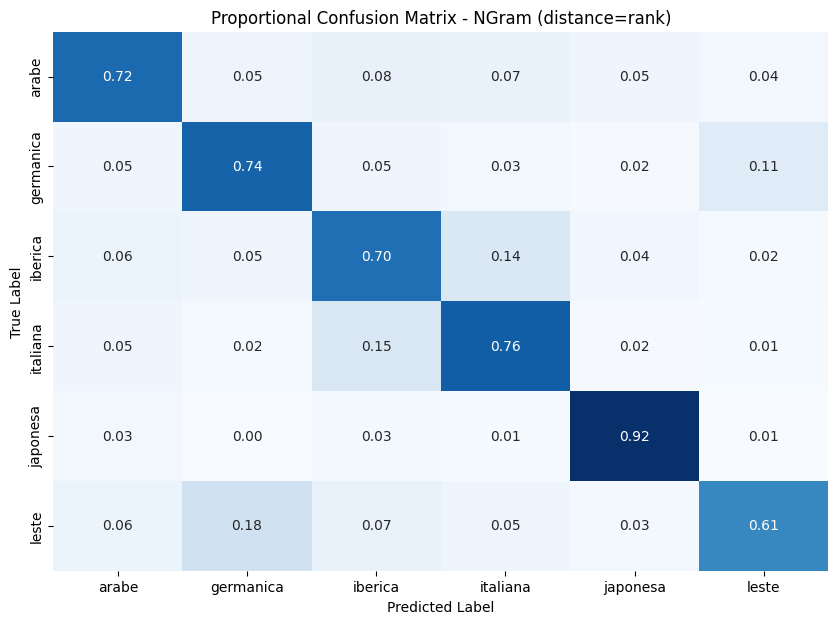

Model: NGram (distance=cosine_tfidf)
Macro F1 Score: 0.6809357400983989
              precision    recall  f1-score   support

       arabe       0.42      0.63      0.50      1174
   germanica       0.75      0.73      0.74      3128
     iberica       0.60      0.73      0.66      3798
    italiana       0.85      0.70      0.77      6686
    japonesa       0.83      0.84      0.84      2635
       leste       0.61      0.55      0.58      1471

    accuracy                           0.71     18892
   macro avg       0.68      0.70      0.68     18892
weighted avg       0.74      0.71      0.72     18892



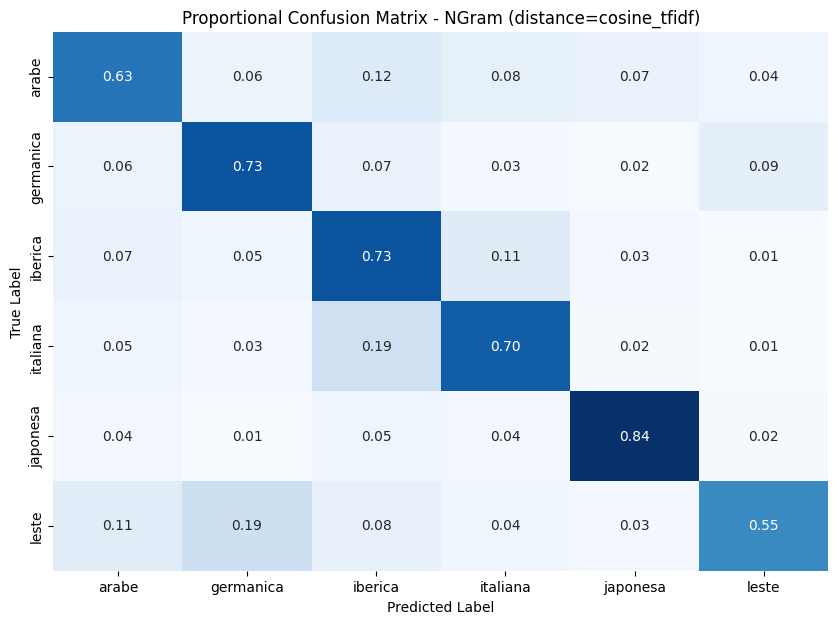

Model: NGram (distance=match_rate)
Macro F1 Score: 0.6039454187203618
              precision    recall  f1-score   support

       arabe       0.26      0.79      0.40      1174
   germanica       0.68      0.72      0.70      3128
     iberica       0.47      0.64      0.54      3798
    italiana       0.87      0.47      0.61      6686
    japonesa       0.89      0.75      0.82      2635
       leste       0.68      0.47      0.56      1471

    accuracy                           0.61     18892
   macro avg       0.64      0.64      0.60     18892
weighted avg       0.71      0.61      0.62     18892



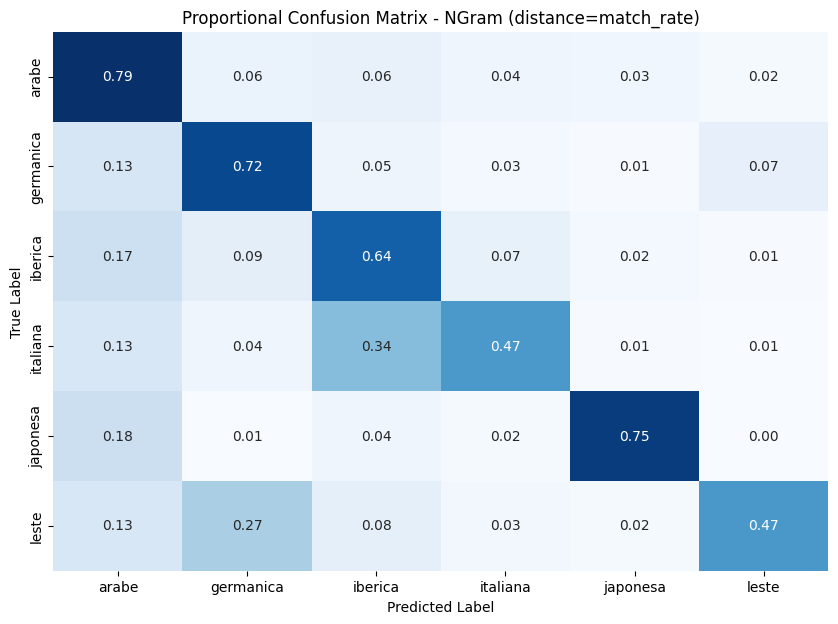

Model: LIGA (log=False, median=False)
Macro F1 Score: 0.5632307253298837
              precision    recall  f1-score   support

       arabe       0.28      0.45      0.34      1174
   germanica       0.71      0.67      0.69      3128
     iberica       0.55      0.52      0.53      3798
    italiana       0.82      0.64      0.72      6686
    japonesa       0.50      0.86      0.63      2635
       leste       0.63      0.36      0.46      1471

    accuracy                           0.62     18892
   macro avg       0.58      0.58      0.56     18892
weighted avg       0.66      0.62      0.62     18892



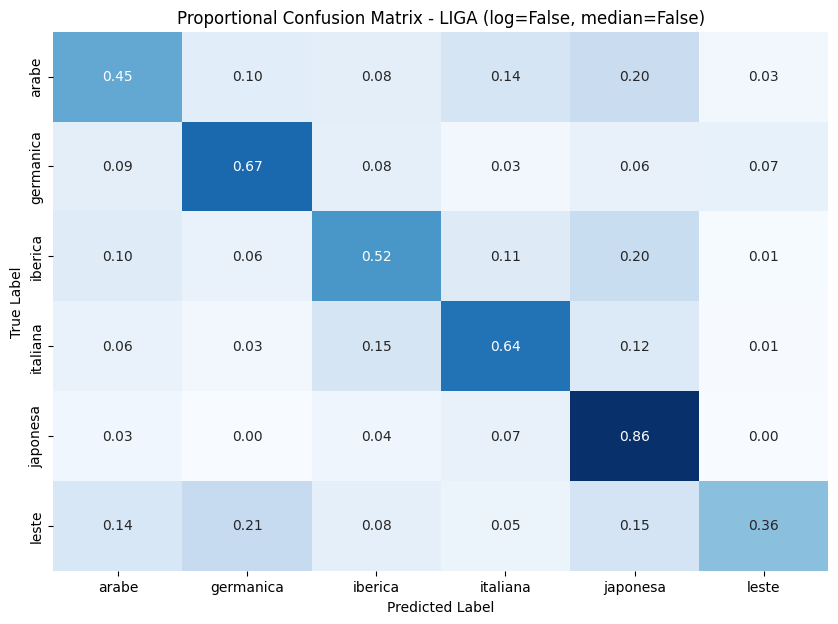

Model: LIGA (log=False, median=True)
Macro F1 Score: 0.6991027675530058
              precision    recall  f1-score   support

       arabe       0.46      0.67      0.55      1174
   germanica       0.76      0.73      0.74      3128
     iberica       0.63      0.69      0.66      3798
    italiana       0.86      0.72      0.78      6686
    japonesa       0.83      0.91      0.87      2635
       leste       0.60      0.58      0.59      1471

    accuracy                           0.73     18892
   macro avg       0.69      0.72      0.70     18892
weighted avg       0.75      0.73      0.73     18892



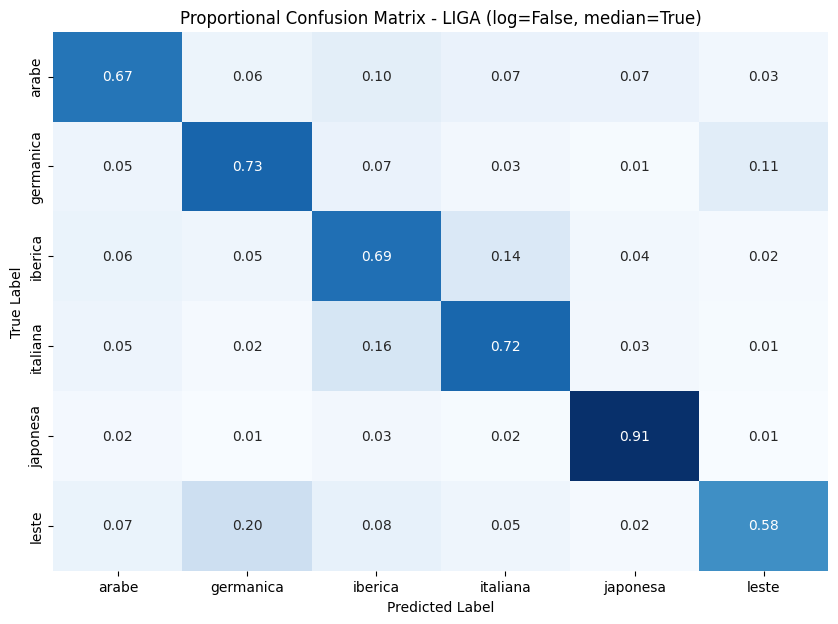

Model: LIGA (log=True, median=False)
Macro F1 Score: 0.5942845483376248
              precision    recall  f1-score   support

       arabe       0.24      0.81      0.38      1174
   germanica       0.92      0.48      0.63      3128
     iberica       0.68      0.56      0.62      3798
    italiana       0.92      0.55      0.69      6686
    japonesa       0.51      0.99      0.67      2635
       leste       0.67      0.52      0.58      1471

    accuracy                           0.62     18892
   macro avg       0.66      0.65      0.59     18892
weighted avg       0.75      0.62      0.63     18892



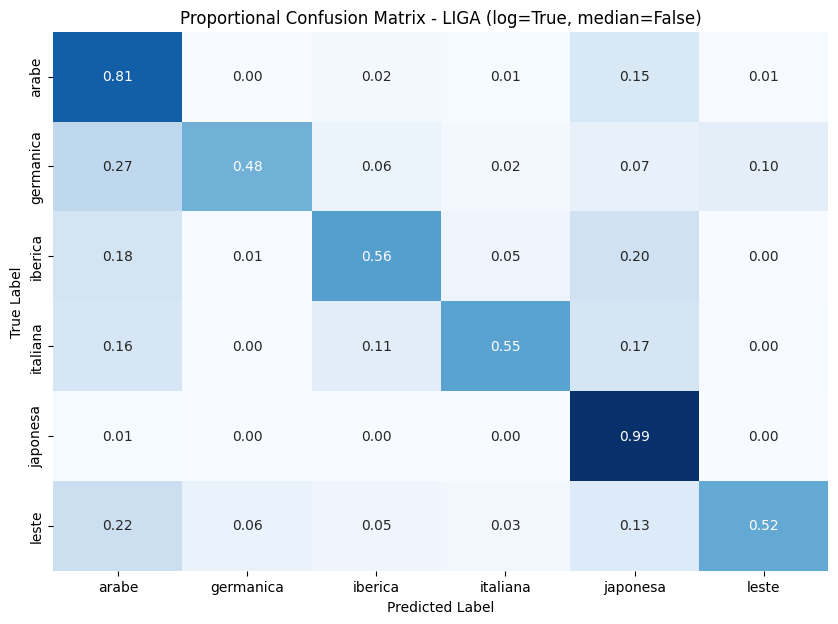

Model: LIGA (log=True, median=True)
Macro F1 Score: 0.60901042276568
              precision    recall  f1-score   support

       arabe       0.28      0.76      0.41      1174
   germanica       0.89      0.51      0.65      3128
     iberica       0.63      0.59      0.61      3798
    italiana       0.87      0.59      0.70      6686
    japonesa       0.57      0.98      0.72      2635
       leste       0.62      0.53      0.57      1471

    accuracy                           0.64     18892
   macro avg       0.64      0.66      0.61     18892
weighted avg       0.73      0.64      0.65     18892



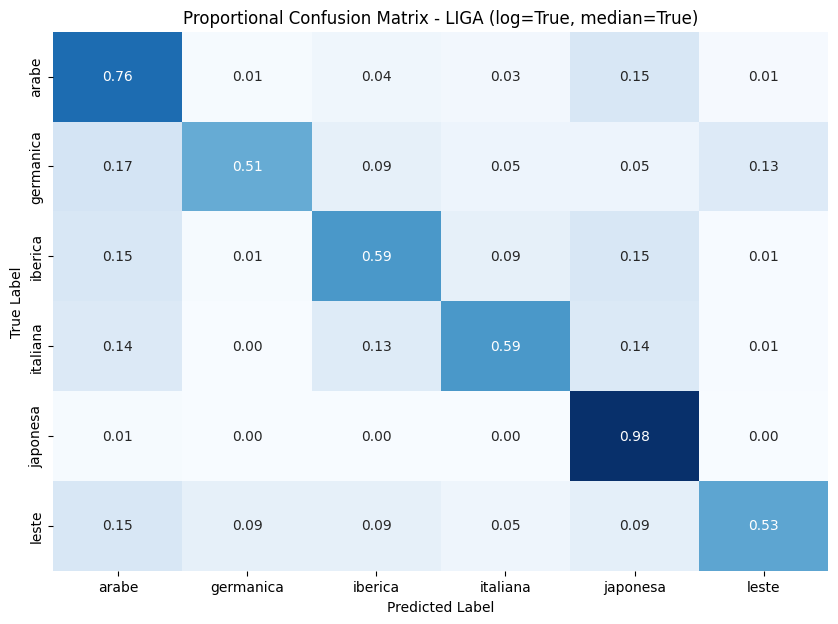

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27645
[LightGBM] [Info] Number of data points in the train set: 75566, number of used features: 115
[LightGBM] [Info] Start training from score -1.132962
[LightGBM] [Info] Start training from score -2.112434
[LightGBM] [Info] Start training from score -2.306594
[LightGBM] [Info] Start training from score -2.872173
[LightGBM] [Info] Start training from score -1.940718
[LightGBM] [Info] Start training from score -1.357892


/home/arthur/Documents/data/ngram_surname_classifiers/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model: NgramEnsemble
Macro F1 Score: 0.7708566540524363
              precision    recall  f1-score   support

       arabe       0.57      0.77      0.65      1174
   germanica       0.83      0.78      0.80      3128
     iberica       0.70      0.79      0.74      3798
    italiana       0.93      0.76      0.84      6686
    japonesa       0.91      0.94      0.92      2635
       leste       0.59      0.75      0.66      1471

    accuracy                           0.80     18892
   macro avg       0.76      0.80      0.77     18892
weighted avg       0.82      0.80      0.80     18892



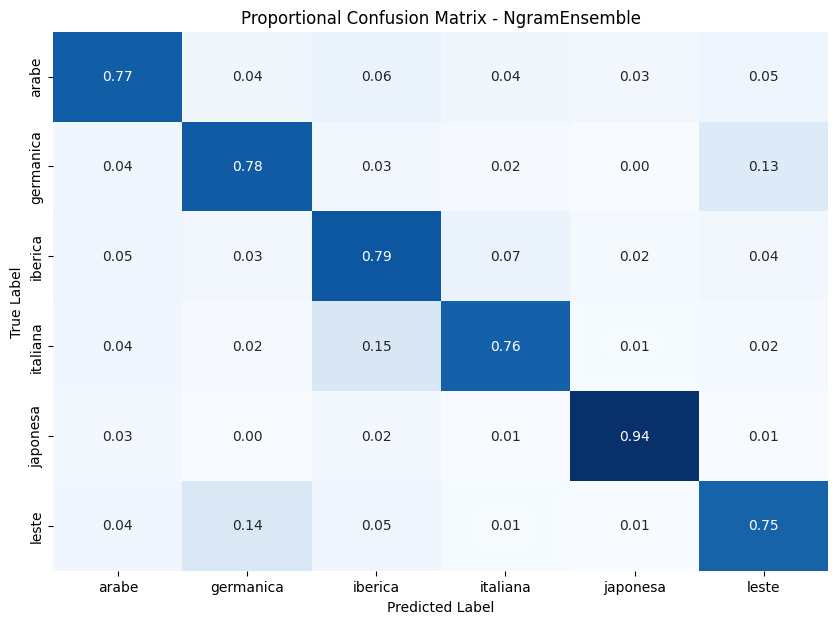

Total time: 128.369793176651


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from time import time

rne_train, rne_test = train_test_split(names_origins_gt, test_size=0.2, stratify=names_origins_gt['origin'], random_state=42)

X_train = rne_train['surname']
y_train = rne_train['origin']
X_test = rne_test['surname']
y_test = rne_test['origin']

start = time()

ngram_distances = ['rank', 'cosine_tfidf', 'match_rate']
ngram_models = {
    f"NGram (distance={dist})": (lambda dist=dist: NGramClassifier(n=3, top_k=1250, distance=dist))
    for dist in ngram_distances
}

# Define LIGA classifiers
liga_models = {
    f"LIGA (log={log}, median={median})": lambda log=log, median=median: LIGAClassifier(n=3, use_log=log, use_median=median)
    for log, median in product([False, True], [False, True])
}

ensemble_model = {
    "NgramEnsemble": lambda: NgramEnsembleClassifier()
}

models_to_evaluate = {**ngram_models, **liga_models, **ensemble_model}


for model_name, model_factory in models_to_evaluate.items():
    clf = model_factory()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(f"Model: {model_name}")
    print(f"Macro F1 Score: {f1_score(y_test, preds, average='macro')}")
    print(classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    cm_prop = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    labels = np.unique(y_test)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_prop, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Proportional Confusion Matrix - {model_name}')
    plt.show()

print(f"Total time: {time() - start}")

# Avaliação estatística

In [22]:
all_classifier_results = pd.read_csv(os.path.join('test', 'all_results.csv'))

all_classifier_results

,iteration,fold,is_holdout,model_name,parameter_setting,execution_time,arabe_f1_score,germanica_f1_score,iberica_f1_score,italiana_f1_score,japonesa_f1_score,leste_f1_score,macro_avg_f1_score
0,1,1,False,NGram (distance=rank),distance=rank,1.056701,0.571179,0.764682,0.676088,0.801678,0.876521,0.614871,0.717503
1,1,2,False,NGram (distance=rank),distance=rank,1.032802,0.584914,0.761066,0.681590,0.802539,0.878357,0.622500,0.721828
2,1,3,False,NGram (distance=rank),distance=rank,1.060154,0.567450,0.760563,0.679239,0.803354,0.879540,0.626117,0.719377
3,1,4,False,NGram (distance=rank),distance=rank,1.342401,0.598195,0.747664,0.678054,0.808263,0.890614,0.599180,0.720328
4,1,5,False,NGram (distance=rank),distance=rank,1.056913,0.589663,0.761944,0.673104,0.800796,0.881647,0.625689,0.722141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,30,2,False,NgramEnsemble,NgramEnsemble,98.975682,0.670037,0.783662,0.745014,0.835099,0.924977,0.654326,0.768852
1436,30,3,False,NgramEnsemble,NgramEnsemble,99.998999,0.662890,0.790179,0.740925,0.834944,0.927239,0.646001,0.767029
1437,30,4,False,NgramEnsemble,NgramEnsemble,98.408878,0.689719,0.802788,0.740274,0.837148,0.928804,0.672587,0.778553
1438,30,5,False,NgramEnsemble,NgramEnsemble,99.072462,0.684626,0.783961,0.732491,0.837002,0.927069,0.667425,0.772096


In [23]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

df = all_classifier_results

# Filter only holdout results for t-tests
holdout_df = df[df["is_holdout"] == True]

# List of all models (excluding the ensemble for comparison)
all_models = sorted(df["model_name"].unique())
ensemble_name = [m for m in all_models if "Ensemble" in m][0]
other_models = [m for m in all_models if m != ensemble_name]

# Calculate mean ± margin of error for 95% CI for all folds
fold_df = df[df["is_holdout"] == False]
summary_stats = []

def margin_of_error(series, confidence=0.95):
    stderr = series.std(ddof=1) / np.sqrt(len(series))
    moe = stderr * 1.96  # 95% confidence
    return moe

for model in all_models:
    model_data = fold_df[fold_df["model_name"] == model]
    row = {"Model": model}

    # Macro F1
    macro_f1s = model_data["macro_avg_f1_score"].dropna()
    # row["Macro F1 Mean"] = macro_f1s.mean()
    # row["Macro F1 MoE"] = margin_of_error(macro_f1s)
    row['Macro F1 Mean +- MoE'] = f"{macro_f1s.mean():.4f} ± {margin_of_error(macro_f1s):.4f}"

    # Per class
    for label in ["iberica", "italiana", "japonesa", "germanica", "arabe", "leste"]:
        col = f"{label}_f1_score"
        scores = model_data[col].dropna()
        # row[f"{label} Mean"] = scores.mean()
        # row[f"{label} MoE"] = margin_of_error(scores)
        row[f"{label} Mean +- MoE"] = f"{scores.mean():.4f} ± {margin_of_error(scores):.4f}"

    summary_stats.append(row)

summary_df = pd.DataFrame(summary_stats).sort_values(by="Macro F1 Mean +- MoE", ascending=False)

display(summary_df)

# Paired one-tailed t-tests: ensemble vs each other model on holdout macro F1
ttest_results = []
ensemble_scores = holdout_df[holdout_df["model_name"] == ensemble_name].sort_values(by='iteration')["macro_avg_f1_score"].values

for model in other_models:
    model_scores = holdout_df[holdout_df["model_name"] == model].sort_values(by='iteration')["macro_avg_f1_score"].values
    t_stat, p_two_tailed = ttest_rel(ensemble_scores, model_scores)
    p_one_tailed = p_two_tailed / 2 if t_stat > 0 else 1 - p_two_tailed / 2
    cohen_d = (ensemble_scores - model_scores).mean() / (ensemble_scores - model_scores).std(ddof=1)

    ttest_results.append({
        "Compared Model": model,
        "t-statistic": f"{t_stat:.4f}",
        "p-value": f"{p_one_tailed:.2e}",
        "Significant (p < .05)": p_one_tailed < 0.05,
        "Cohen's d": f"{cohen_d:.4f}"
    })

ttest_df = pd.DataFrame(ttest_results).sort_values(by="p-value", ascending=False)
display(ttest_df)

,Model,Macro F1 Mean +- MoE,iberica Mean +- MoE,italiana Mean +- MoE,japonesa Mean +- MoE,germanica Mean +- MoE,arabe Mean +- MoE,leste Mean +- MoE
7,NgramEnsemble,0.7709 ± 0.0005,0.7396 ± 0.0008,0.8344 ± 0.0006,0.9256 ± 0.0006,0.7924 ± 0.0009,0.6729 ± 0.0016,0.6601 ± 0.0014
6,NGram (distance=rank),0.7204 ± 0.0006,0.6771 ± 0.0009,0.8049 ± 0.0007,0.8815 ± 0.0008,0.7597 ± 0.0009,0.5832 ± 0.0017,0.6157 ± 0.0018
1,"LIGA (log=False, median=True)",0.7011 ± 0.0006,0.6561 ± 0.0009,0.7812 ± 0.0007,0.8691 ± 0.0007,0.7477 ± 0.0010,0.5453 ± 0.0016,0.6069 ± 0.0017
4,NGram (distance=cosine_tfidf),0.6860 ± 0.0006,0.6577 ± 0.0009,0.7696 ± 0.0007,0.8411 ± 0.0009,0.7403 ± 0.0010,0.5153 ± 0.0016,0.5918 ± 0.0018
3,"LIGA (log=True, median=True)",0.6205 ± 0.0007,0.6124 ± 0.0011,0.7019 ± 0.0010,0.7316 ± 0.0009,0.6639 ± 0.0014,0.4223 ± 0.0013,0.5909 ± 0.0016
5,NGram (distance=match_rate),0.6043 ± 0.0007,0.5466 ± 0.0011,0.6153 ± 0.0013,0.8159 ± 0.0014,0.6965 ± 0.0010,0.4027 ± 0.0013,0.5484 ± 0.0022
2,"LIGA (log=True, median=False)",0.6024 ± 0.0007,0.6230 ± 0.0012,0.6795 ± 0.0012,0.6877 ± 0.0010,0.6446 ± 0.0014,0.3782 ± 0.0012,0.6016 ± 0.0017
0,"LIGA (log=False, median=False)",0.5683 ± 0.0007,0.5409 ± 0.0012,0.7156 ± 0.0008,0.6392 ± 0.0011,0.6801 ± 0.0012,0.3681 ± 0.0019,0.4658 ± 0.0021


,Compared Model,t-statistic,p-value,Significant (p < .05),Cohen's d
4,NGram (distance=cosine_tfidf),175.5819,9.44e-46,True,32.0567
5,NGram (distance=match_rate),223.7349,8.41e-49,True,40.8482
3,"LIGA (log=True, median=True)",224.0830,8.04e-49,True,40.9118
6,NGram (distance=rank),86.3407,7.89e-37,True,15.7636
1,"LIGA (log=False, median=True)",122.3254,3.32e-41,True,22.3335
0,"LIGA (log=False, median=False)",234.9324,2.04e-49,True,42.8926
2,"LIGA (log=True, median=False)",237.0020,1.58e-49,True,43.2704


In [24]:
margins = []

for model in all_models:
    model_data = fold_df[fold_df["model_name"] == model]
    row = {"Model": model}

    # Macro F1
    macro_f1s = model_data["macro_avg_f1_score"].dropna()
    row["Macro F1 Mean"] = macro_f1s.mean()
    row["Macro F1 MoE"] = margin_of_error(macro_f1s)
    # row['Macro F1 Mean +- MoE'] = f"{macro_f1s.mean():.4f} ± {margin_of_error(macro_f1s):.4f}"

    # Per class
    for label in ["iberica", "italiana", "japonesa", "germanica", "arabe", "leste"]:
        col = f"{label}_f1_score"
        scores = model_data[col].dropna()
        row[f"{label} Mean"] = scores.mean()
        row[f"{label} MoE"] = margin_of_error(scores)
        # row[f"{label} Mean +- MoE"] = f"{scores.mean():.4f} ± {margin_of_error(scores):.4f}"

    margins.append(row)

margins_df = pd.DataFrame(margins).sort_values(by="Macro F1 Mean", ascending=False)

display(margins_df)

,Model,Macro F1 Mean,Macro F1 MoE,iberica Mean,iberica MoE,italiana Mean,italiana MoE,japonesa Mean,japonesa MoE,germanica Mean,germanica MoE,arabe Mean,arabe MoE,leste Mean,leste MoE
7,NgramEnsemble,0.770868,0.000549,0.739643,0.000837,0.834450,0.000642,0.925621,0.000626,0.792440,0.000901,0.672912,0.001610,0.660140,0.001430
6,NGram (distance=rank),0.720370,0.000598,0.677138,0.000904,0.804922,0.000671,0.881515,0.000775,0.759741,0.000924,0.583213,0.001656,0.615693,0.001771
1,"LIGA (log=False, median=True)",0.701060,0.000563,0.656117,0.000905,0.781168,0.000688,0.869143,0.000727,0.747706,0.000983,0.545316,0.001602,0.606909,0.001709
4,NGram (distance=cosine_tfidf),0.685961,0.000582,0.657720,0.000921,0.769612,0.000709,0.841109,0.000871,0.740263,0.001011,0.515264,0.001580,0.591798,0.001785
3,"LIGA (log=True, median=True)",0.620516,0.000657,0.612446,0.001125,0.701869,0.000995,0.731598,0.000938,0.663921,0.001379,0.422321,0.001345,0.590942,0.001605
5,NGram (distance=match_rate),0.604253,0.000703,0.546614,0.001057,0.615332,0.001323,0.815919,0.001403,0.696518,0.001024,0.402733,0.001301,0.548399,0.002189
2,"LIGA (log=True, median=False)",0.602444,0.000660,0.623050,0.001180,0.679533,0.001223,0.687688,0.000980,0.644579,0.001442,0.378195,0.001150,0.601622,0.001745
0,"LIGA (log=False, median=False)",0.568296,0.000681,0.540924,0.001240,0.715595,0.000788,0.639174,0.001083,0.680125,0.001157,0.368134,0.001860,0.465824,0.002110


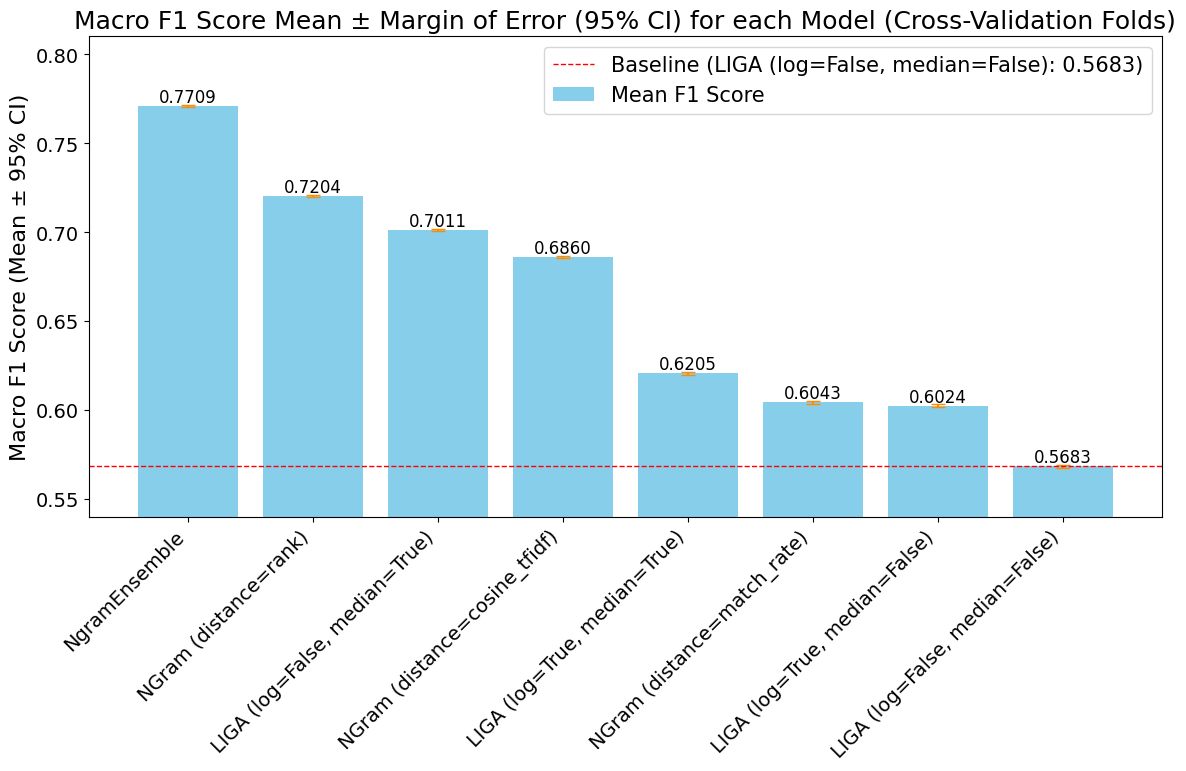

In [25]:
import matplotlib.pyplot as plt

# Increase global font size
plt.rcParams.update({
    'font.size': 16,            # Base font size
    'axes.titlesize': 18,       # Title font size
    'axes.labelsize': 16,       # Axis label font size
    'xtick.labelsize': 14,      # X-axis tick font size
    'ytick.labelsize': 14,      # Y-axis tick font size
    'legend.fontsize': 15,      # Legend font size
})

# Sort the DataFrame by Macro F1 Mean for plotting
margins_df_sorted = margins_df.sort_values(by="Macro F1 Mean", ascending=False)

# Define colors for bars and error bars
bar_color = 'skyblue'
error_bar_color = 'darkorange'

plt.figure(figsize=(12, 8))

# Get the baseline (lowest Macro F1 Mean)
baseline = margins_df_sorted["Macro F1 Mean"].iloc[-1]
baseline_model = margins_df_sorted["Model"].iloc[-1]

# Create the bar plot
bars = plt.bar(
    margins_df_sorted["Model"],
    margins_df_sorted["Macro F1 Mean"],
    yerr=margins_df_sorted["Macro F1 MoE"],
    capsize=5,
    color=bar_color,
    ecolor=error_bar_color,
    label='Mean F1 Score'
)

# Add the baseline line
plt.axhline(baseline, color='red', linestyle='--', linewidth=1, label=f'Baseline ({baseline_model}: {baseline:.4f})')

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)

plt.ylabel('Macro F1 Score (Mean ± 95% CI)')
plt.title('Macro F1 Score Mean ± Margin of Error (95% CI) for each Model (Cross-Validation Folds)')
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=baseline * 0.95)  # Adjust y-axis to start slightly below baseline
plt.tight_layout()
plt.legend()
plt.show()


In [28]:
import joblib

# Use all ground truth data for training
X_all = names_origins_gt['surname'].values
y_all = names_origins_gt['origin'].values

output_models_dir = os.path.join(data_root, 'outputs')
os.makedirs(output_models_dir, exist_ok=True)

for model_name, model_factory in models_to_evaluate.items():
    clf = model_factory()
    clf.fit(X_all, y_all)
    model_filename = f"{model_name.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').replace('=', '_')}.joblib"
    try:
        joblib.dump(clf, os.path.join(output_models_dir, model_filename))
        print(f"Saved {model_name} to {model_filename}")
    except Exception as e:
        print(f"Error saving {model_name}: {e}")

Saved NGram (distance=rank) to NGram_distance_rank.joblib
Saved NGram (distance=cosine_tfidf) to NGram_distance_cosine_tfidf.joblib
Saved NGram (distance=match_rate) to NGram_distance_match_rate.joblib
Error saving LIGA (log=False, median=False): Can't pickle <function LIGAClassifier.__init__.<locals>.<lambda> at 0x71e367e00d60>: it's not found as models.LIGAClassifier.__init__.<locals>.<lambda>
Error saving LIGA (log=False, median=True): Can't pickle <function LIGAClassifier.__init__.<locals>.<lambda> at 0x71e2e6147ce0>: it's not found as models.LIGAClassifier.__init__.<locals>.<lambda>
Error saving LIGA (log=True, median=False): Can't pickle <function LIGAClassifier.__init__.<locals>.<lambda> at 0x71e367e00d60>: it's not found as models.LIGAClassifier.__init__.<locals>.<lambda>
Error saving LIGA (log=True, median=True): Can't pickle <function LIGAClassifier.__init__.<locals>.<lambda> at 0x71e2e6147ce0>: it's not found as models.LIGAClassifier.__init__.<locals>.<lambda>
[LightGBM] [In

KeyboardInterrupt: 